In [1]:
# %%
from pathlib import Path 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from napatrackmater import  create_analysis_cell_type_tracklets, convert_pseudo_tracks_to_simple_arrays
from napatrackmater.Trackvector import (TrackVector,
                                        create_cluster_plot,
                                        cross_correlation_class,
                                        SHAPE_FEATURES, 
                                        DYNAMIC_FEATURES, 
                                        SHAPE_DYNAMIC_FEATURES,
                                        plot_histograms_for_cell_type_groups
                                        
                                        )

/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2024-11-18 12:27:42.632825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 12:27:42.917356: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 12:27:43.685335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.s

In [2]:
dataset_name = 'Sixth'
home_folder = '/home/debian/jz/'
timelapse_to_track = f'timelapse_{dataset_name.lower()}_dataset'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
channel = 'nuclei_'
model_type = 'morpho_dynamic'
model_name = 'morpho_feature_attention_shallowest_litest'
annotations_prediction_dir = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/annotations_predicted_attention_{model_name}_{channel}{model_type}/'

data_frames_dir = os.path.join(tracking_directory, f'dataframes/')
master_xml_name = 'master_' + 'marching_cubes_filled_' + channel + timelapse_to_track + ".xml"
xml_path = Path(os.path.join(tracking_directory, master_xml_name))
oneat_detections = f'/home/debian/jz/Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/oneat_detections/non_maximal_oneat_mitosis_locations_{channel}timelapse_{dataset_name.lower()}_dataset.csv'
     
goblet_cells_file = f'{annotations_prediction_dir}goblet_cells_{channel}annotations_inception.csv'
basal_cells_file = f'{annotations_prediction_dir}basal_cells_{channel}annotations_inception.csv'
radial_cells_file = f'{annotations_prediction_dir}radially_intercalating_cells_{channel}annotations_inception.csv'

goblet_cells_dataframe = pd.read_csv(goblet_cells_file)
basal_cells_dataframe = pd.read_csv(basal_cells_file)
radial_cells_dataframe = pd.read_csv(radial_cells_file)

normalized_dataframe = os.path.join(data_frames_dir , f'results_dataframe_normalized_{channel}.csv')
goblet_basal_radial_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}predicted_{model_name}.csv')


time_delta = 10
block_size = 100
overlap = 50
verbose_generation_plots = False
save_dir = os.path.join(tracking_directory, f'cell_type_clustering_plots_{channel}predicted_{model_name}/')
distribution_dir = os.path.join(tracking_directory, f'cell_type_distribution_plots_{channel}predicted_{model_name}/')
Path(save_dir).mkdir(exist_ok=True, parents=True)
Path(distribution_dir).mkdir(exist_ok=True, parents=True)
method="ward"
criterion="distance"
metric="euclidean" 

shape_cols = SHAPE_FEATURES
dynamic_cols = DYNAMIC_FEATURES
feature_cols = SHAPE_DYNAMIC_FEATURES




In [3]:
track_vectors = TrackVector(master_xml_path=xml_path)
track_vectors.oneat_csv_file = oneat_detections
track_vectors.oneat_threshold_cutoff = 0.9999
track_vectors.t_minus = 0
track_vectors.t_plus = track_vectors.tend
track_vectors.y_start = 0
track_vectors.y_end = track_vectors.ymax
track_vectors.x_start = 0
track_vectors.x_end = track_vectors.xmax

print(f'reading data from {normalized_dataframe}')
tracks_dataframe = pd.read_csv(normalized_dataframe)
if os.path.exists(goblet_basal_radial_dataframe):
    tracks_goblet_basal_radial_dataframe = pd.read_csv(goblet_basal_radial_dataframe)
else:

    track_vectors._interactive_function()
    tracks_goblet_basal_radial_dataframe = tracks_dataframe
    globlet_track_ids = track_vectors._get_trackmate_ids_by_location(goblet_cells_dataframe)
    print(f'Trackmate IDs for globlet cells {globlet_track_ids}')
    basal_track_ids = track_vectors._get_trackmate_ids_by_location(basal_cells_dataframe)
    print(f'Trackmate IDs for basal cells {basal_track_ids}')
    radial_track_ids = track_vectors._get_trackmate_ids_by_location(radial_cells_dataframe)
    print(f'Trackmate IDs for radial cells {radial_track_ids}')

    goblet_df = pd.DataFrame({'TrackMate Track ID': globlet_track_ids, 'Cell_Type': 'Goblet'})
    basal_df = pd.DataFrame({'TrackMate Track ID': basal_track_ids, 'Cell_Type': 'Basal'})
    radial_df = pd.DataFrame({'TrackMate Track ID': radial_track_ids, 'Cell_Type': 'Radial'})

    basal_radial_dataframe = pd.concat([goblet_df, basal_df, radial_df], ignore_index=True)
    basal_radial_dataframe['TrackMate Track ID'] = basal_radial_dataframe['TrackMate Track ID'].astype(str)
    tracks_goblet_basal_radial_dataframe['TrackMate Track ID'] = tracks_goblet_basal_radial_dataframe['TrackMate Track ID'].astype(str)


    for index, row in tracks_goblet_basal_radial_dataframe.iterrows():
            track_id = row['TrackMate Track ID']
            match_row = basal_radial_dataframe[basal_radial_dataframe['TrackMate Track ID'] == track_id]
            if not match_row.empty:
                cell_type = match_row.iloc[0]['Cell_Type']
                tracks_goblet_basal_radial_dataframe.at[index, 'Cell_Type'] = cell_type

    tracks_goblet_basal_radial_dataframe.to_csv(goblet_basal_radial_dataframe, index=False)
        


Reading Master XML
reading data from /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/dataframes/results_dataframe_normalized_nuclei_.csv


In [4]:
len(tracks_goblet_basal_radial_dataframe['TrackMate Track ID'].unique())

3938

In [5]:
unique_cell_types = tracks_goblet_basal_radial_dataframe[~tracks_goblet_basal_radial_dataframe['Cell_Type'].isna()]['Cell_Type'].unique()

print("Number of unique cell types:", len(unique_cell_types))
print("Unique cell types:", unique_cell_types)
cell_type_label_mapping = {
    "Basal": 1,
    "Radial":2, 
    "Goblet":3
}
label_cell_type_mapping = {v: k for k, v in cell_type_label_mapping.items()}
print("Cell type counts, unique TrackMate Track IDs, and count of mitotic tracks:")
for cell_type in unique_cell_types:
    cell_type_df = tracks_goblet_basal_radial_dataframe[tracks_goblet_basal_radial_dataframe['Cell_Type'] == cell_type]
    unique_track_ids = cell_type_df['TrackMate Track ID'].unique()
    
    dividing_count = 0
    for track_id in unique_track_ids:
        track_df = cell_type_df[cell_type_df['TrackMate Track ID'] == track_id]
        if track_df['Dividing'].iloc[0] == 1:
            dividing_count += 1
    
    count = len(cell_type_df)
    print(f"{cell_type}: {count} rows, unique TrackMate Track IDs: {len(unique_track_ids)}, mitotic tracks: {dividing_count}")

cell_type_dataframe = tracks_goblet_basal_radial_dataframe[~tracks_goblet_basal_radial_dataframe['Cell_Type'].isna()]
cell_type_dataframe['Cell_Type'].unique()
print(cell_type_label_mapping)
cell_type_dataframe.loc[:, 'Cell_Type_Label'] = cell_type_dataframe['Cell_Type'].map(cell_type_label_mapping)

correlation_dataframe = cell_type_dataframe.copy()

len(correlation_dataframe['TrackMate Track ID'].unique())

Number of unique cell types: 3
Unique cell types: ['Basal' 'Goblet' 'Radial']
Cell type counts, unique TrackMate Track IDs, and count of mitotic tracks:
Basal: 365743 rows, unique TrackMate Track IDs: 2044, mitotic tracks: 664
Goblet: 257677 rows, unique TrackMate Track IDs: 1603, mitotic tracks: 286
Radial: 33753 rows, unique TrackMate Track IDs: 215, mitotic tracks: 29
{'Basal': 1, 'Radial': 2, 'Goblet': 3}


/tmp/ipykernel_992646/2121466336.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_type_dataframe.loc[:, 'Cell_Type_Label'] = cell_type_dataframe['Cell_Type'].map(cell_type_label_mapping)


3862

In [6]:
correlation_dataframe.head()

,Unnamed: 0,Track ID,t,z,y,x,Dividing,Number_Dividing,Radius,Eccentricity_Comp_First,...,Cell_Axis_Z,Cell_Axis_Y,Cell_Axis_X,MSD,TrackMate Track ID,Generation ID,Tracklet Number ID,Track Duration,Cell_Type,Cell_Type_Label
3,19446,8400.0,0.0,11.588732,898.332394,1194.332394,0.0,0.0,-3.242878,-2.752968,...,0.063557,0.232524,0.233329,0.0,84,0,0,2053,Basal,1
5,27058,11500.0,0.0,10.308116,794.481431,1118.541953,1.0,2.0,-1.786590,-1.261601,...,0.366748,-0.337416,-0.337119,0.0,115,0,0,92089,Basal,1
6,23194,9800.0,0.0,8.729968,1032.201482,1113.491894,0.0,0.0,2.468788,0.281101,...,1.134091,-0.457335,-0.459605,0.0,98,0,0,751,Basal,1
7,5848,2500.0,0.0,10.858926,1105.725343,916.707865,0.0,0.0,-1.519581,-1.625806,...,0.721631,0.106572,0.106898,0.0,25,0,0,304,Basal,1
8,1079,400.0,0.0,11.023272,1214.339493,1234.757016,0.0,0.0,0.577708,-0.707199,...,1.427934,-0.564088,-0.555457,0.0,4,0,0,3254,Basal,1


In [ ]:
t_start = 0
t_delta = time_delta
t_total = max(cell_type_dataframe['t'])
starting_label_shape_dynamic = 0
starting_label_dynamic = 0
starting_label_shape = 0

copy_celltype_dataframe = cell_type_dataframe.copy()


local_cell_type_dataframe_dict = {}
all_new_columns = {}
for i in tqdm(np.arange(t_start, t_total, t_delta)):
                local_analysis_vectors, local_shape_dynamic_dataframe = create_analysis_cell_type_tracklets(copy_celltype_dataframe, t_minus=i, t_plus=i + t_delta, cell_type='Cell_Type_Label') 

               
                result =  convert_pseudo_tracks_to_simple_arrays(local_analysis_vectors,t_delta = t_delta)
                
               
                if result is not None:
                        ( local_shape_dynamic_covariance_2d,
                        local_shape_covariance_2d,
                        local_dynamic_covariance_2d, 
                        local_shape_dynamic_cluster_labels_dict, 
                        local_shape_cluster_labels_dict, 
                        local_dynamic_cluster_labels_dict,
                       
                        local_cluster_distance_map_shape_dynamic_dict,
                        local_cluster_distance_map_shape_dict,
                        local_cluster_distance_map_dynamic_dict,
                        local_cluster_eucledian_distance_map_shape_dynamic_dict,
                        local_cluster_eucledian_distance_map_shape_dict,
                        local_cluster_eucledian_distance_map_dynamic_dict,
                        local_analysis_track_ids) = result
                        local_shape_dynamic_dataframe = local_shape_dynamic_dataframe.copy()
                        all_new_columns.update({
                        f"Shape Dynamic Cluster_{i}": local_shape_dynamic_dataframe["Track ID"].map(local_shape_dynamic_cluster_labels_dict),
                        f"Shape Cluster_{i}": local_shape_dynamic_dataframe["Track ID"].map(local_shape_cluster_labels_dict),
                        f"Dynamic Cluster_{i}": local_shape_dynamic_dataframe["Track ID"].map(local_dynamic_cluster_labels_dict),
                        f"Shape Dynamic CellType Distance_{i}": local_shape_dynamic_dataframe["Track ID"].map(local_cluster_distance_map_shape_dynamic_dict),
                        f"Shape CellType Distance_{i}": local_shape_dynamic_dataframe["Track ID"].map(local_cluster_distance_map_shape_dict),
                        f"Dynamic CellType Distance_{i}": local_shape_dynamic_dataframe["Track ID"].map(local_cluster_distance_map_dynamic_dict),
                        f"Shape Dynamic CellType Eucledian Distance_{i}": local_shape_dynamic_dataframe["Track ID"].map(local_cluster_eucledian_distance_map_shape_dynamic_dict),
                        f"Shape CellType Eucledian Distance_{i}": local_shape_dynamic_dataframe["Track ID"].map(local_cluster_eucledian_distance_map_shape_dict),
                        f"Dynamic CellType Eucledian Distance_{i}": local_shape_dynamic_dataframe["Track ID"].map(local_cluster_eucledian_distance_map_dynamic_dict)
                        })
                        
                        
copy_celltype_dataframe = copy_celltype_dataframe.assign(**all_new_columns)

In [ ]:
unique_col_names = ["Cluster_CellType_Distances", "Cluster_CellType_Eucledian_Distances", "Cluster_Label_Type"]
cluster_extended_dynamic_dataframe = create_cluster_plot(dataframe=copy_celltype_dataframe, cluster_type='Dynamic Cluster', cluster_distance_type='Dynamic CellType Distance',cluster_eucledian_distance_type='Dynamic CellType Eucledian Distance',  negate_cluster_distance_type='Shape Dynamic CellType Distance',negate_cluster_eucledian_distance_type='Shape Dynamic CellType Eucledian Distance',unique_col_names=unique_col_names )
cluster_extended_shape_dynamic_dataframe = create_cluster_plot(dataframe=copy_celltype_dataframe, cluster_type='Shape Dynamic Cluster', cluster_distance_type= 'Shape Dynamic CellType Distance', cluster_eucledian_distance_type= 'Shape Dynamic CellType Eucledian Distance',unique_col_names=unique_col_names)
cluster_extended_shape_dataframe = create_cluster_plot(dataframe=copy_celltype_dataframe, cluster_type='Shape Cluster',cluster_distance_type='Shape CellType Distance', cluster_eucledian_distance_type='Shape CellType Eucledian Distance', negate_cluster_distance_type='Shape Dynamic CellType Distance', negate_cluster_eucledian_distance_type='Shape Dynamic CellType Eucledian Distance',unique_col_names=unique_col_names)


In [ ]:

hue_options = [ "Shape_Cluster_CellType_Distances" ]
cluster_plots = ["MSD"] + SHAPE_DYNAMIC_FEATURES
shape_save_dir = os.path.join(save_dir, 'CellFate_Shape_Clustering/')
Path(shape_save_dir).mkdir(exist_ok=True, parents=True)
cell_type = list(map(int, cluster_extended_shape_dataframe["Shape_Cluster_Label_Type"].unique()))
key_list = [label_cell_type_mapping[value] for value in cell_type]

for index, cell_type_index in enumerate(cell_type):
        cell_type_label = key_list[index]
        for cluster_plot in cluster_plots:
                    filtered_tracks = cluster_extended_shape_dataframe[cluster_extended_shape_dataframe["Shape_Cluster_Label_Type"] == cell_type_index]
                    for hue_option in hue_options:  
                        plt.figure(figsize=(15, 6))
                        scatter = plt.scatter(filtered_tracks['t'],filtered_tracks[cluster_plot],c=filtered_tracks[hue_option],cmap='viridis')
                        plt.xlabel('Time (t)')
                        plt.ylabel(f'{cluster_plot}_{cell_type_label}')
                    
                        plt.colorbar(scatter, label = hue_option)
                        plt.title(f'Cell Type based clustering')
                        fig_name = f"{channel}{cluster_plot}_{hue_option}_{cell_type_label}_all.png"
                        plt.savefig(os.path.join(shape_save_dir, fig_name))
                        plt.show()

        for count, hue_option in enumerate(hue_options):    
                        unique_t_values = filtered_tracks['t'].unique()     
                        t_values = []
                        mean_update_column_values = []     
                        for t_value in unique_t_values:
                            filtered_data_t = filtered_tracks[filtered_tracks['t'] == t_value]
                            mean_update_column = filtered_data_t[hue_option].mean()
                            t_values.append(t_value)
                            mean_update_column_values.append(mean_update_column)    
                        plt.figure(figsize=(15, 6))
                        plt.plot(t_values, mean_update_column_values, marker='o')  
                        plt.xlabel('Time (t)')
                        plt.ylabel(f'Shape feature distance_{cell_type_label}')
                        plt.title(f'Pseudo_Shape feature {hue_option}')
                        fig_name = f"pseudo_{channel}{hue_option}_{cell_type_label}_line_plot_all.png"
                        plt.savefig(os.path.join(shape_save_dir, fig_name))
                        plt.show() 






                


### Lets get the distribution of shape and dynamic features for each cell type

In [ ]:
t_max = correlation_dataframe['t'].max()
time_blocks = []
start = 0
while start < t_max:
    end = min(start + block_size, t_max)
    time_blocks.append((start, end))
    start += overlap
for start, end in time_blocks:
    cell_type_save_path = os.path.join(tracking_directory, f'cell_type_data_{start}_end_t_{end}_{channel}/')
    Path(cell_type_save_path).mkdir(parents=True, exist_ok=True)
    sliced_df = correlation_dataframe[(correlation_dataframe['t'] >= start) & (correlation_dataframe['t'] < end)]

    track_vectors.plot_cell_type_times(sliced_df, save_path = cell_type_save_path)
    print(f'Start time {start}, End time {end}')
    name = f't_start_{start}_t_end_{end}'
    plot_histograms_for_cell_type_groups(cell_type_save_path, distribution_dir, dataset_name, channel, label_dict = label_cell_type_mapping, name = name)


### Cross Correlation Features

/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/home/debian/anaconda3/envs/capedenv/lib/python3.1

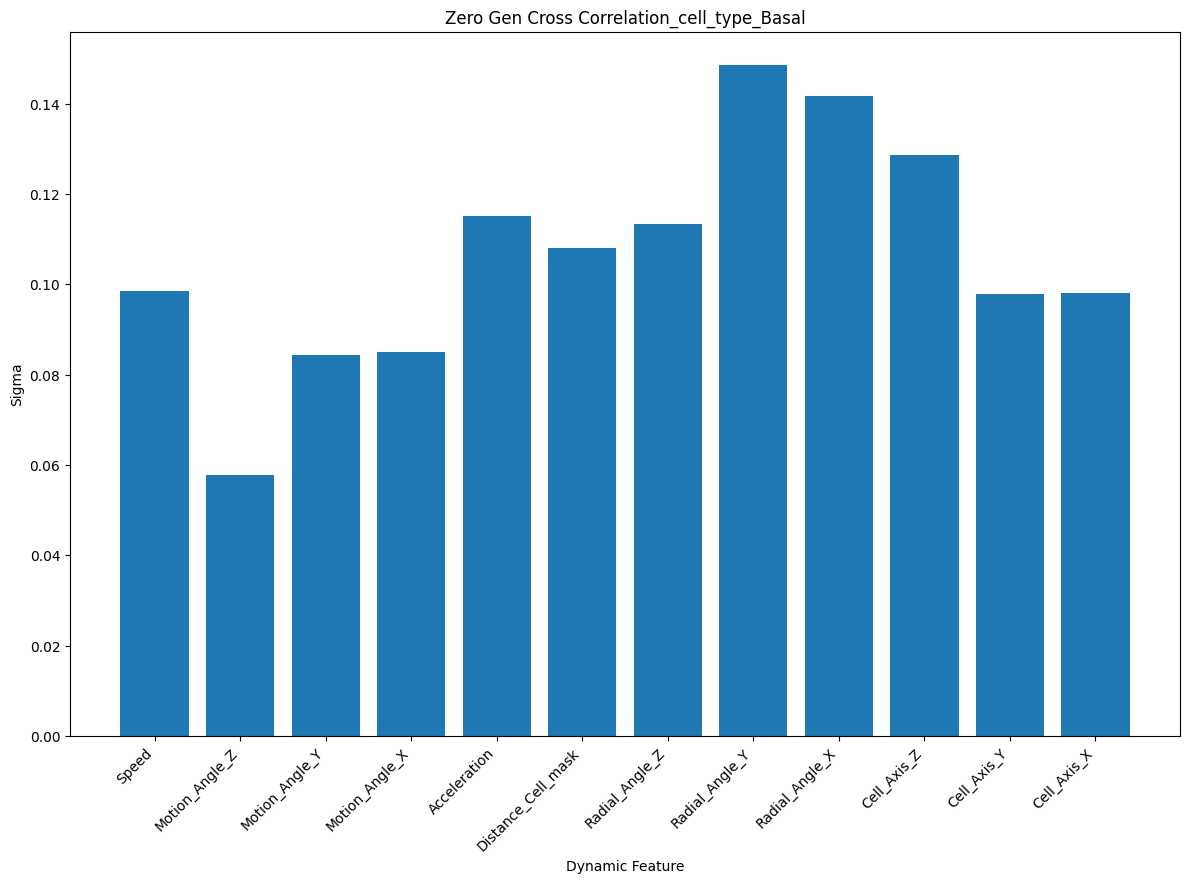

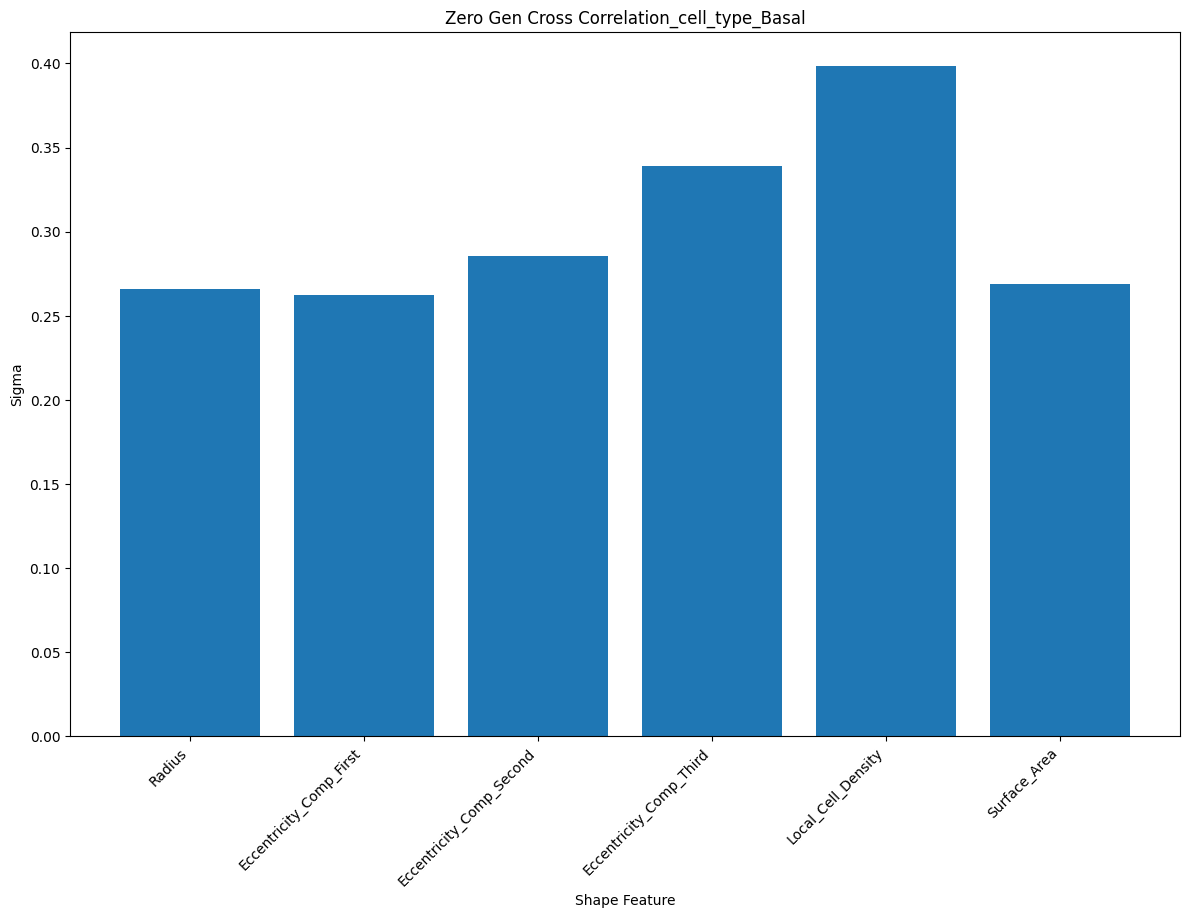

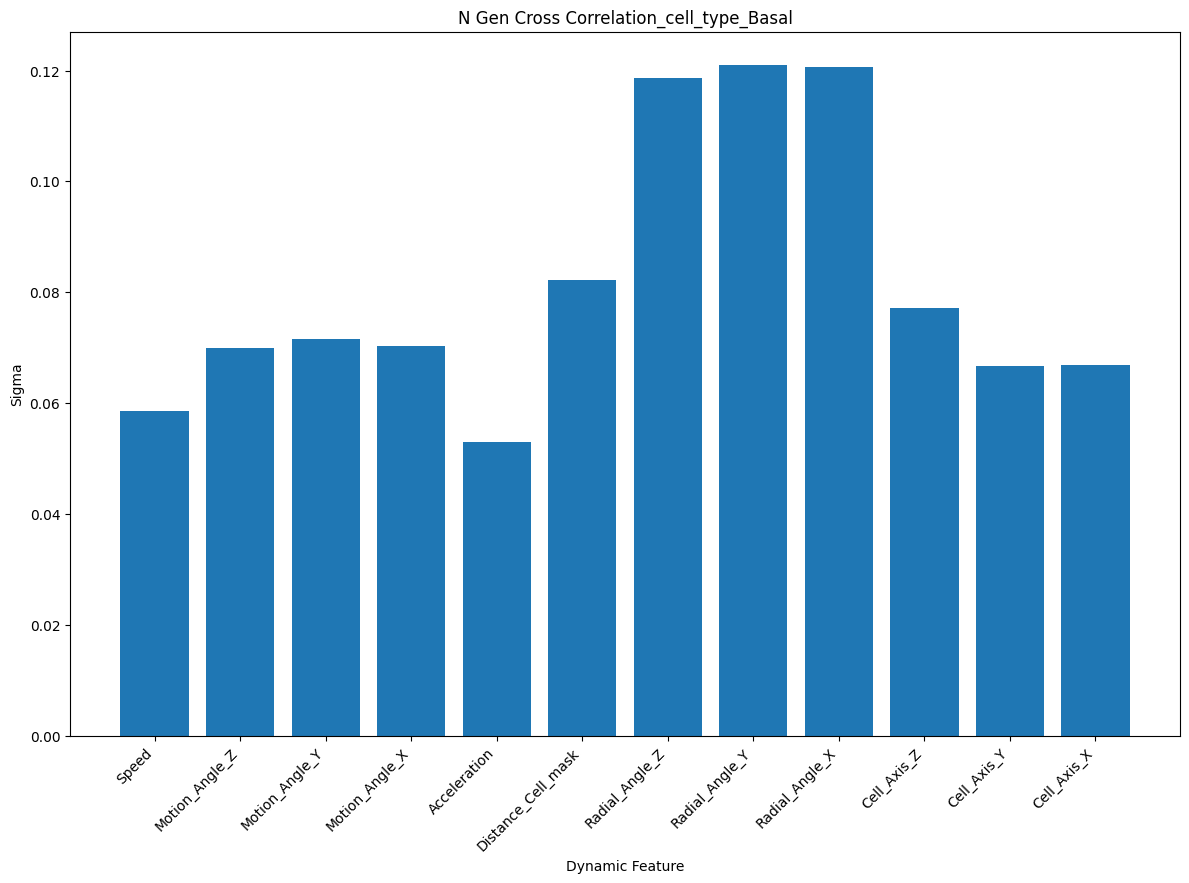

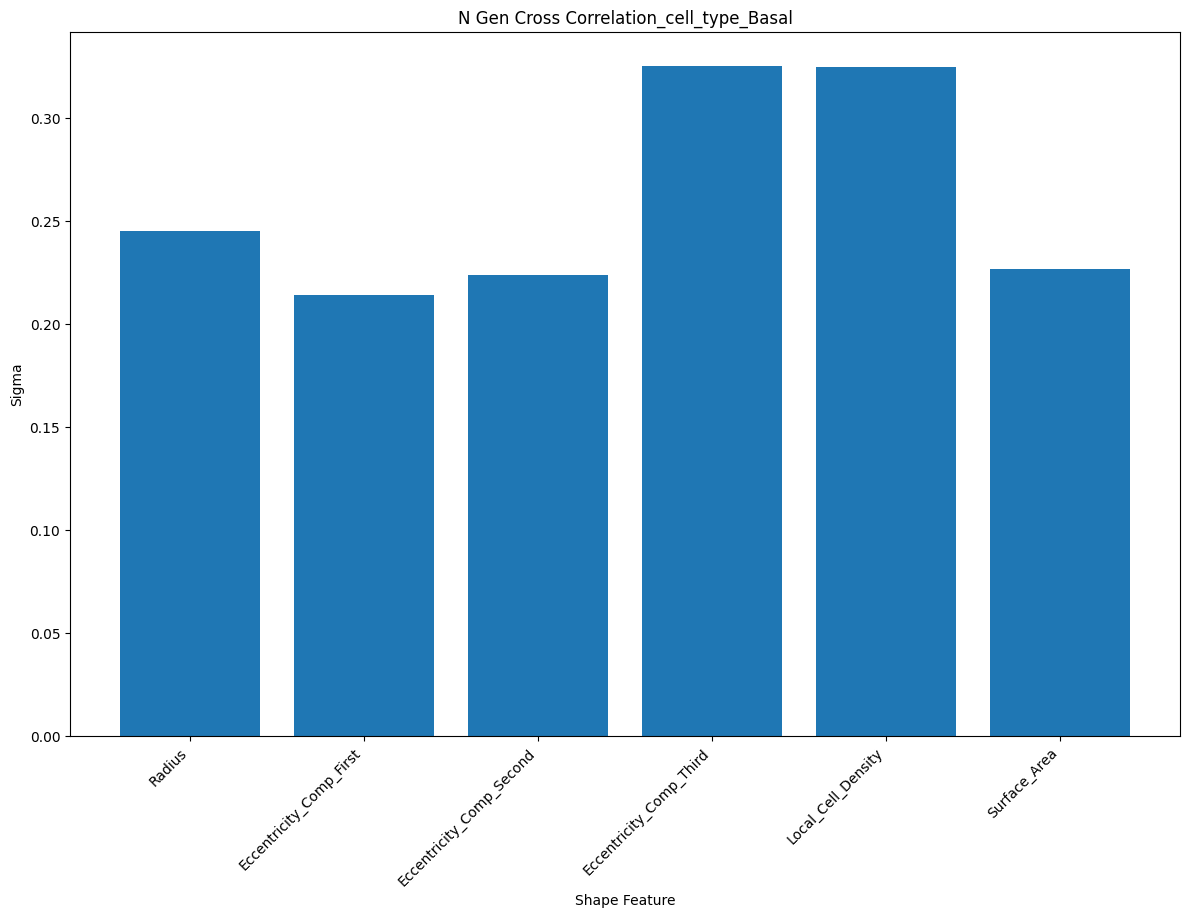

/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/home/debian/anaconda3/envs/capedenv/lib/python3.1

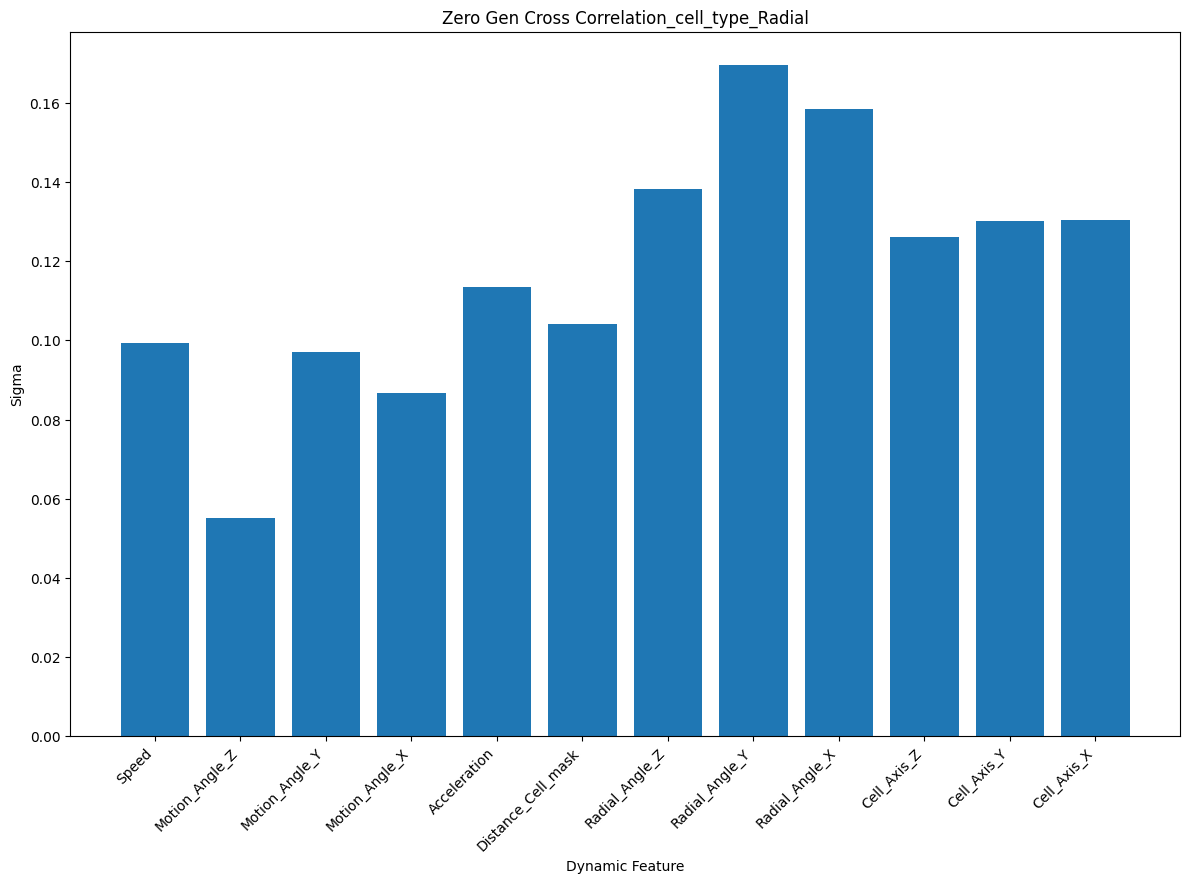

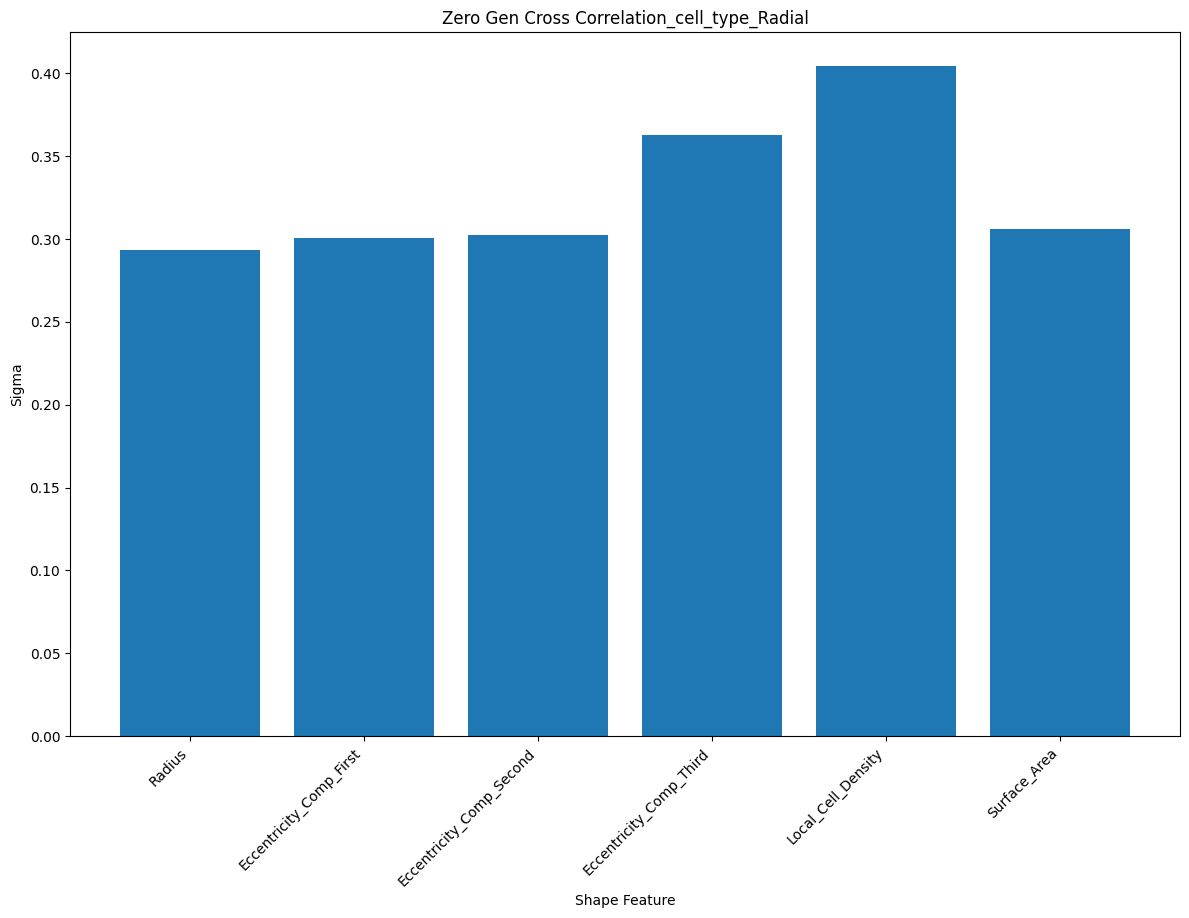

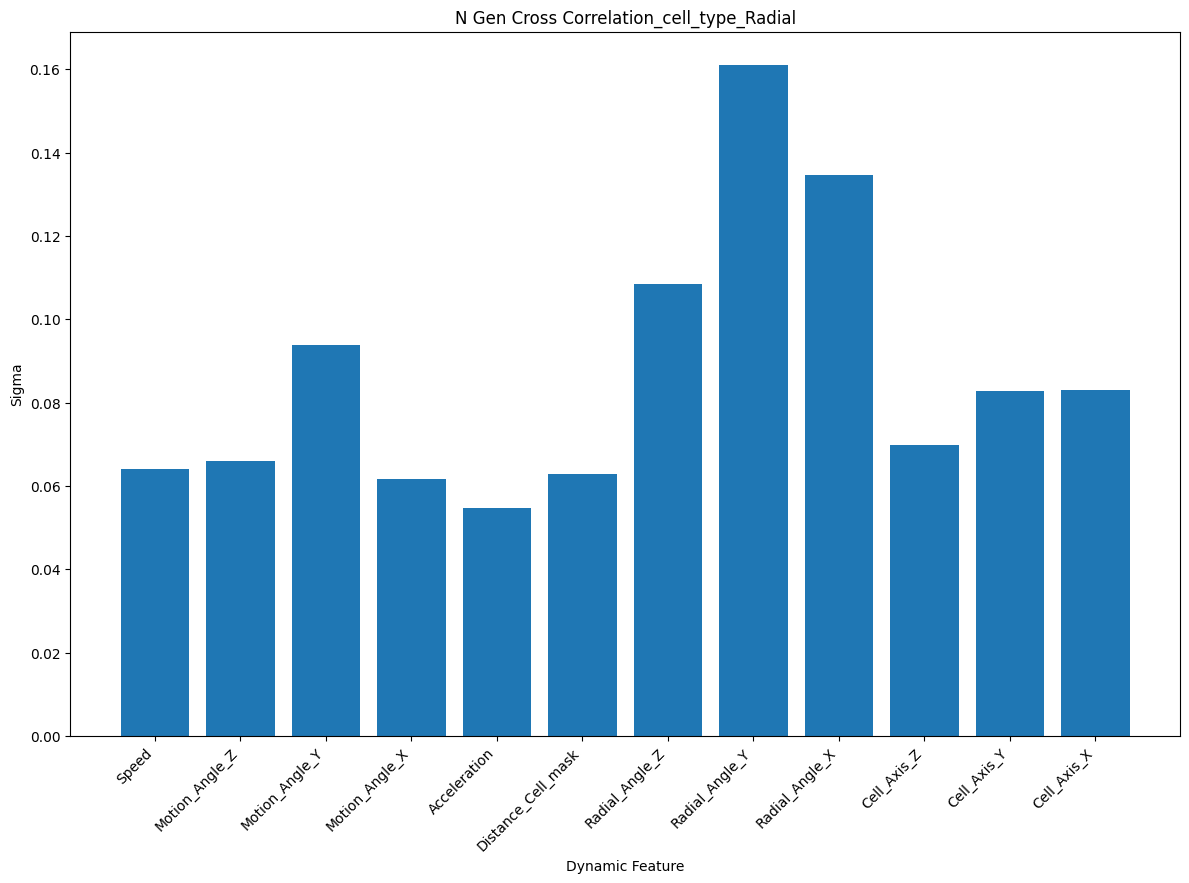

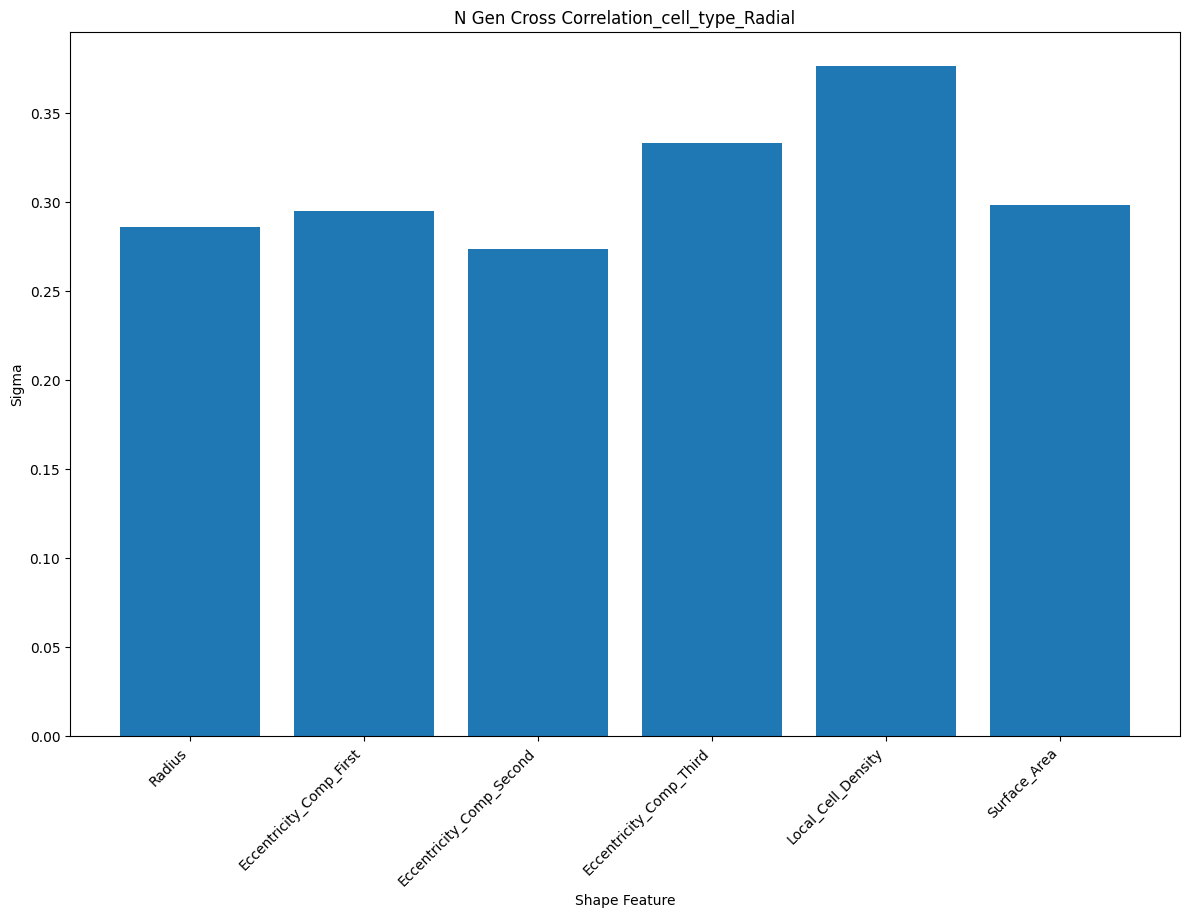

/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1179: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))
/home/debian/anaconda3/envs/capedenv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]
/home/debian/anaconda3/envs/capedenv/lib/python3.1

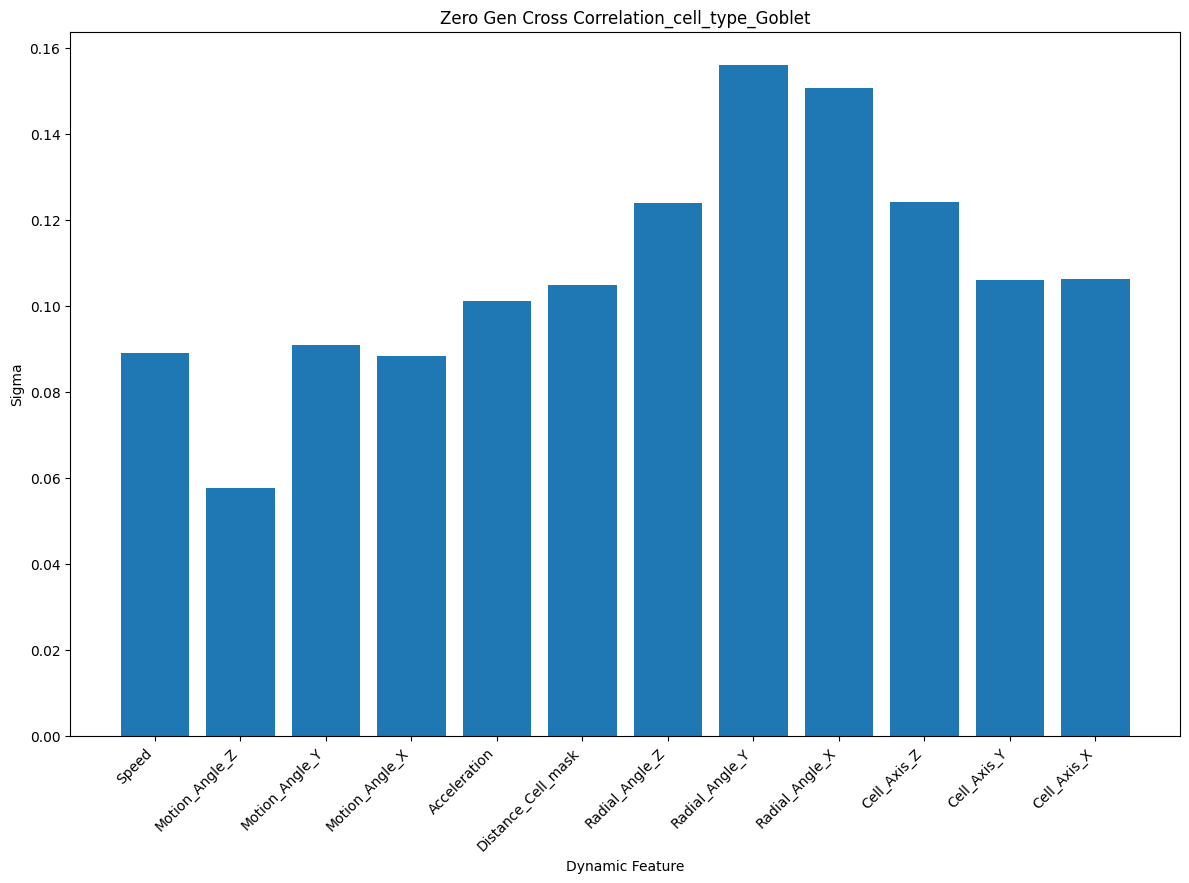

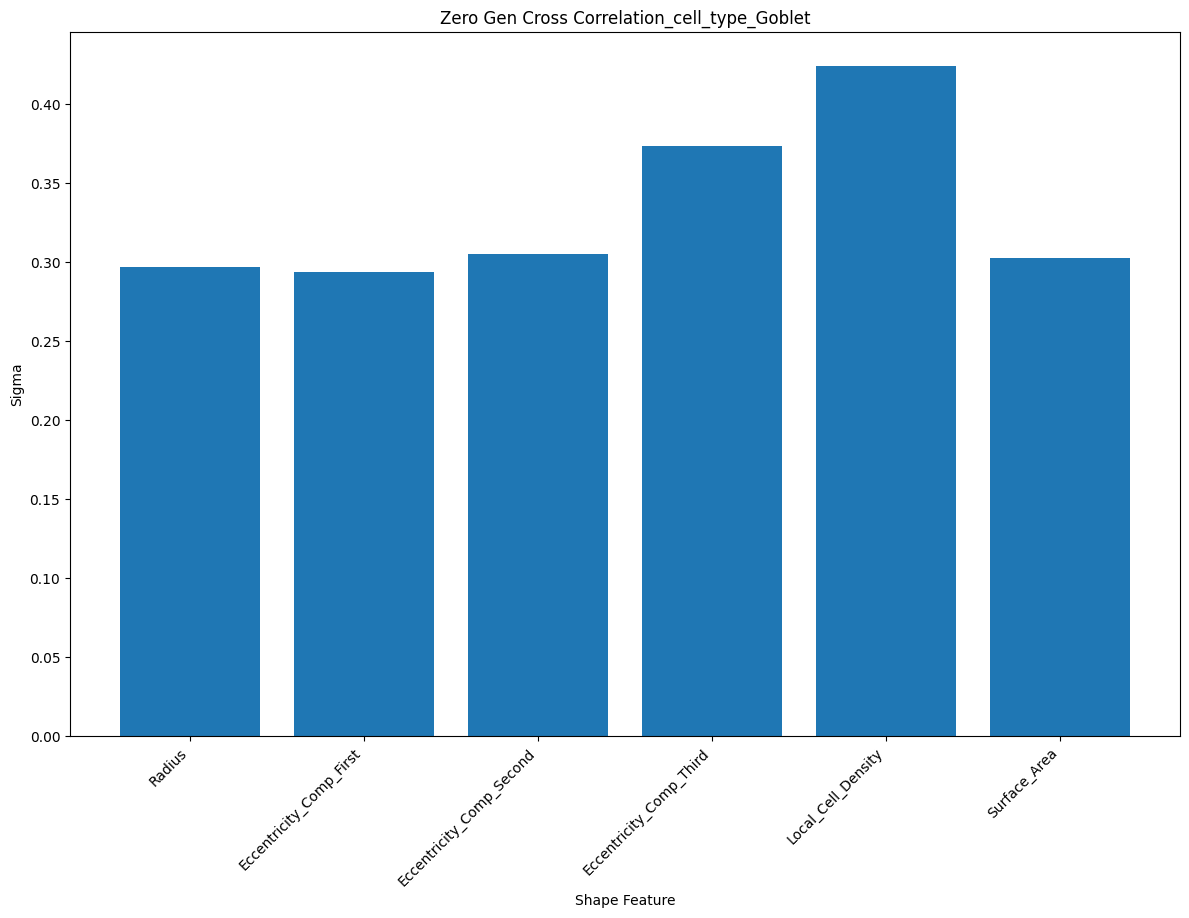

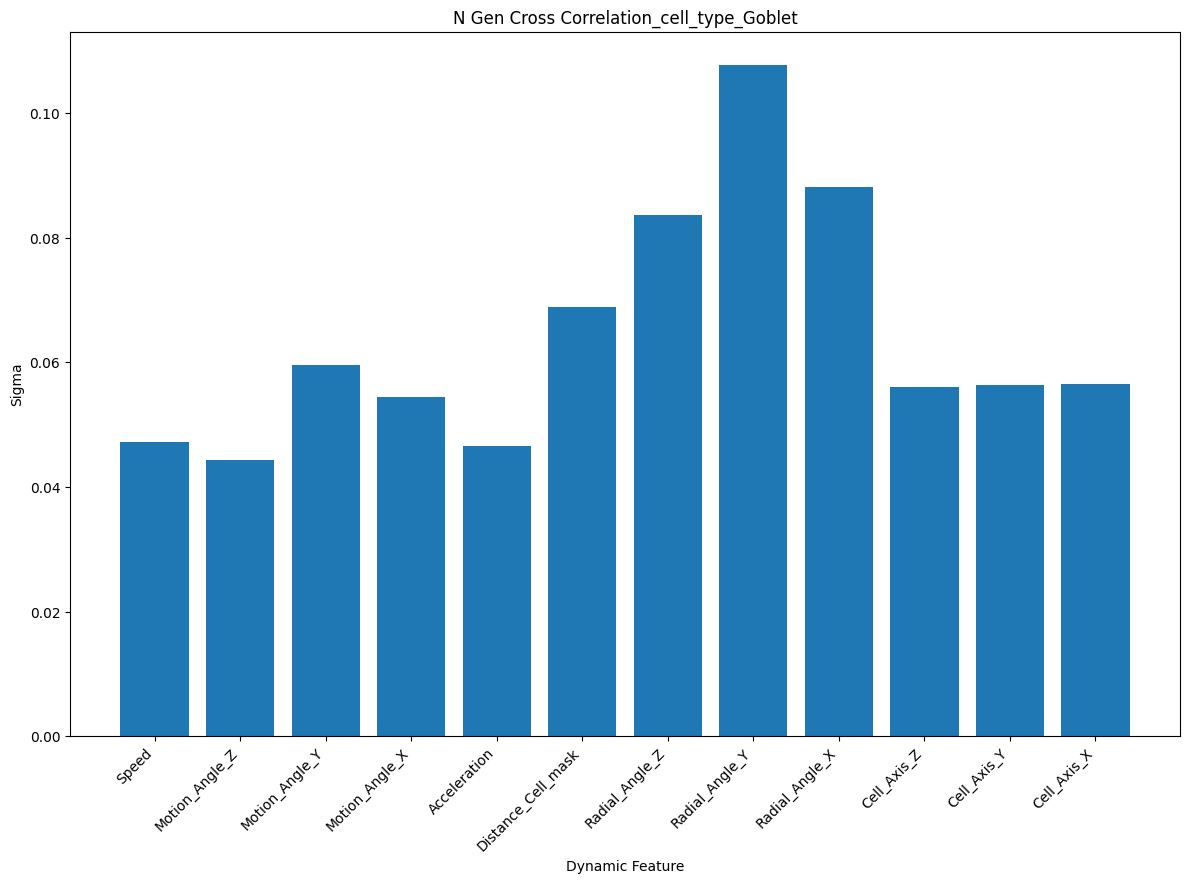

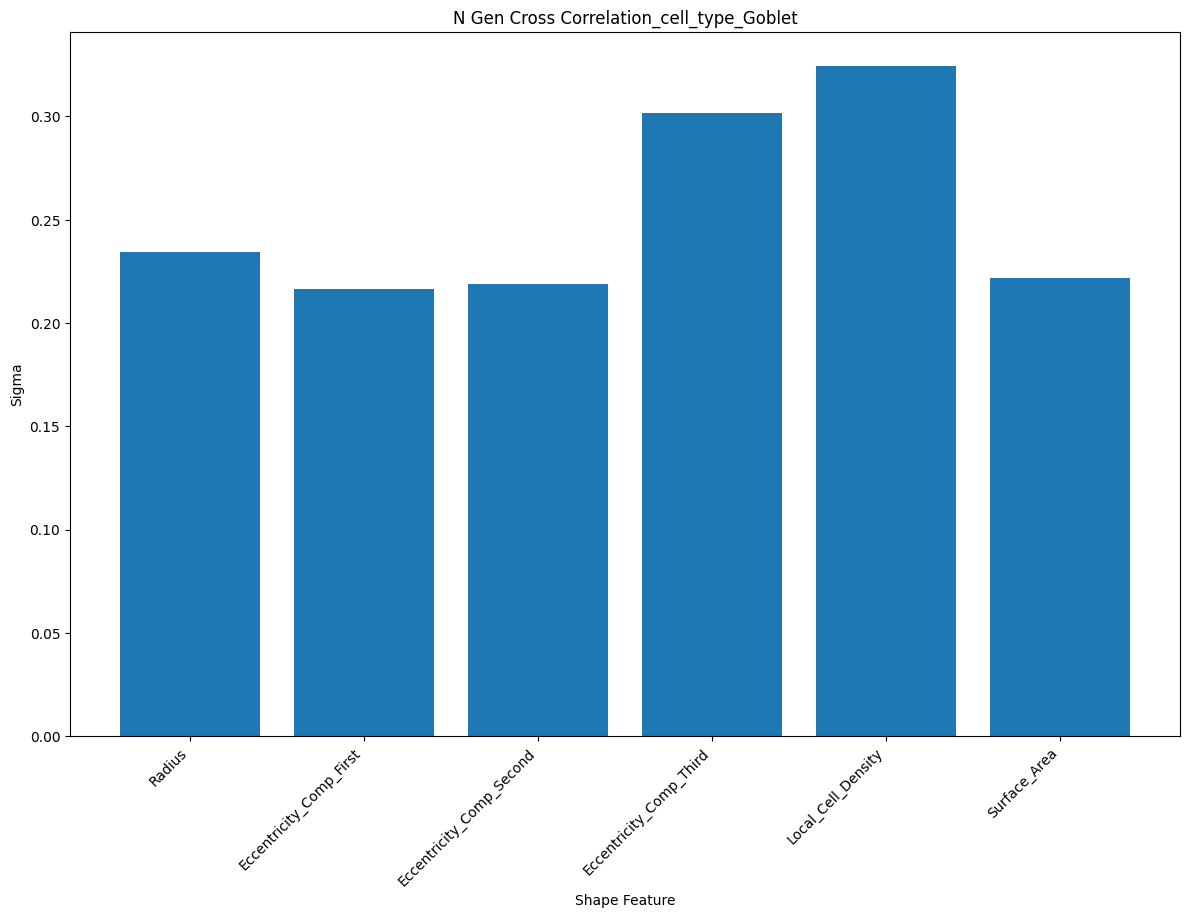

In [8]:

for cell_type, cell_type_label in cell_type_label_mapping.items():
        cell_type_result = cross_correlation_class(correlation_dataframe, cell_type_label = cell_type_label)

        (zero_gen_dynamic_conccross, zero_gen_shape_conccross, 
        N_gen_dynamic_conccross, N_gen_shape_conccross,
        zero_gen_dynamic_sigma_dict, zero_gen_shape_sigma_dict, 
        N_gen_dynamic_sigma_dict, N_gen_shape_sigma_dict, 
        zero_gen_dynamic_test_dict, zero_gen_shape_test_dict, 
        N_gen_dynamic_test_dict, N_gen_shape_test_dict)     = cell_type_result

        for dynamic_feature in zero_gen_dynamic_conccross.keys():

            concatenated_crosscorrs = zero_gen_dynamic_conccross[dynamic_feature] 
            if verbose_generation_plots:
                plt.figure(figsize=(12, 8)) 
                sns.displot(concatenated_crosscorrs, kde=True)
                plt.xlabel('Zero Gen Cross correlation')
                plt.ylabel('Frequency')
                plt.title(f'Histogram with Gaussian Fit of {dynamic_feature}_cell_type_{cell_type}_{channel}')
                plt.show()

        for shape_feature in zero_gen_shape_conccross.keys():

            concatenated_crosscorrs = zero_gen_shape_conccross[shape_feature] 
            if verbose_generation_plots:
                plt.figure(figsize=(12, 8)) 
                sns.displot(concatenated_crosscorrs, kde=True)
                plt.xlabel('Zero Gen Cross correlation')
                plt.ylabel('Frequency')
                plt.title(f'Histogram with Gaussian Fit of {shape_feature}_cell_type_{cell_type}_{channel}')
                plt.show() 

        for dynamic_feature in N_gen_dynamic_conccross.keys():

            concatenated_crosscorrs = N_gen_dynamic_conccross[dynamic_feature] 
            if verbose_generation_plots:
                plt.figure(figsize=(12, 8)) 
                sns.displot(concatenated_crosscorrs, kde=True)
                plt.xlabel('N Gen Cross correlation')
                plt.ylabel('Frequency')
                plt.title(f'Histogram with Gaussian Fit of {dynamic_feature}_cell_type_{cell_type}_{channel}')
                plt.show()

        for shape_feature in N_gen_shape_conccross.keys():

            concatenated_crosscorrs = zero_gen_shape_conccross[shape_feature]
            if verbose_generation_plots: 
                plt.figure(figsize=(12, 8)) 
                sns.displot(concatenated_crosscorrs, kde=True)
                plt.xlabel('N Gen Cross correlation')
                plt.ylabel('Frequency')
                plt.title(f'Histogram with Gaussian Fit of {shape_feature}_cell_type_{cell_type}_{channel}')
                plt.show()

        plt.figure(figsize=(12, 8)) 
        plt.bar(zero_gen_dynamic_sigma_dict.keys(), zero_gen_dynamic_sigma_dict.values())
        plt.xlabel('Dynamic Feature')
        plt.ylabel('Sigma')
        plt.title(f'Zero Gen Cross Correlation_cell_type_{cell_type}')
        plt.tight_layout()
        plt.xticks(rotation=45, ha='right') 
        fig_name = f"{channel}cell_type_{cell_type}_{channel}_dynamic_zero_gen_cross_correlation_sigmas.png"
        plt.savefig(os.path.join(distribution_dir, fig_name), dpi=300, bbox_inches='tight')
        plt.show()   

        plt.figure(figsize=(12, 8)) 
        plt.bar(zero_gen_shape_sigma_dict.keys(), zero_gen_shape_sigma_dict.values())
        plt.xlabel('Shape Feature')
        plt.ylabel('Sigma')
        plt.title(f'Zero Gen Cross Correlation_cell_type_{cell_type}')
        plt.tight_layout()
        plt.xticks(rotation=45, ha='right') 
        fig_name = f"{channel}cell_type_{cell_type}_{channel}_shape_zero_gen_cross_correlation_sigmas.png"
        plt.savefig(os.path.join(distribution_dir, fig_name), dpi=300, bbox_inches='tight')
        plt.show()   

        plt.figure(figsize=(12, 8)) 
        plt.bar(N_gen_dynamic_sigma_dict.keys(), N_gen_dynamic_sigma_dict.values())
        plt.xlabel('Dynamic Feature')
        plt.ylabel('Sigma')
        plt.title(f'N Gen Cross Correlation_cell_type_{cell_type}')
        plt.tight_layout()
        plt.xticks(rotation=45, ha='right') 
        fig_name = f"{channel}cell_type_{cell_type}_{channel}_dynamic_N_gen_cross_correlation_sigmas.png"
        plt.savefig(os.path.join(distribution_dir, fig_name), dpi=300, bbox_inches='tight')
        plt.show()   

        plt.figure(figsize=(12, 8)) 
        plt.bar(N_gen_shape_sigma_dict.keys(), N_gen_shape_sigma_dict.values())
        plt.xlabel('Shape Feature')
        plt.ylabel('Sigma')
        plt.title(f'N Gen Cross Correlation_cell_type_{cell_type}')
        plt.tight_layout()
        plt.xticks(rotation=45, ha='right') 
        fig_name = f"{channel}cell_type_{cell_type}_{channel}_shape_N_gen_cross_correlation_sigmas.png"
        plt.savefig(os.path.join(distribution_dir, fig_name), dpi=300, bbox_inches='tight')
        plt.show() 

